In [73]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [108]:
df = pd.read_csv("../datasets/SENT/train.tsv", sep="\t", header=None)

In [109]:
def replace_contraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text
def replace_links(text, filler=' '):
        text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                      filler, text).strip()
        return text
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [110]:
import re
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = replace_contraction(text)
    text = replace_links(text, "link")
    text = remove_numbers(text)
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text

In [111]:
X = np.array(df[0].apply(cleanText))
y = np.array(df[1])
del df

In [112]:
test_df = pd.read_csv("../datasets/SENT/test.tsv", sep="\t", header=None)

In [113]:
X_test = np.array(test_df[0].apply(cleanText))
y_test = np.array(test_df[1])
del test_df

In [114]:
# One hot Encoding of y
encoder = LabelEncoder()
encoder.fit(y)

y = encoder.transform(y)
y = to_categorical(y)

# One hot Encoding of y test
y_oh = encoder.transform(y_test)
y_oh = to_categorical(y_oh)

In [157]:
embed = hub.Module("../model/elmo/")
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [158]:
import tensorflow.keras as keras 
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

In [159]:
def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense1 = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    dense2 = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense1)
    dense3 = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense2)
    pred = Dense(3, activation='sigmoid')(dense3)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [160]:
model_elmo = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [161]:
model_elmo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 394,755
Trainable params: 394,755
Non-trainable params: 0
_________________________________________________________________


In [19]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(X, y, epochs=5, batch_size=8, validation_split = 0.001)
    model_elmo.save_weights('../model/elmo/model_elmo_2_weights.h5')

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 161135 samples, validate on 162 samples
Epoch 1/5
161135/161135 [==============================] - 7910s 49ms/step - loss: 0.7858 - acc: 0.6846 - val_loss: 0.6545 - val_acc: 0.7593
Epoch 2/5
161135/161135 [==============================] - 7770s 48ms/step - loss: 0.7437 - acc: 0.6997 - val_loss: 0.6661 - val_acc: 0.7901
Epoch 3/5
161135/161135 [==============================] - 7724s 48ms/step - loss: 0.7404 - acc: 0.7016 - val_loss: 0.6903 - val_acc: 0.7654
Epoch 4/5
161135/161135 [==============================] - 7802s 48ms/step - loss: 0.7364 - acc: 0.7032 - val_loss: 0.6445 - val_acc: 0.7284
Epoch 5/5
161135/161135 [==============================] - 7799s 48ms/step - loss: 0.7374 - acc: 0.7023 - val_loss: 0.6317 - val_acc: 0.7654


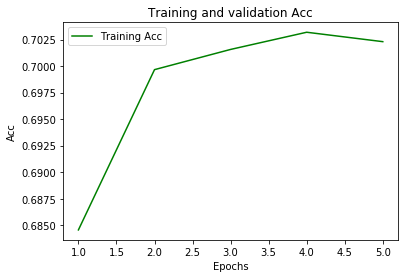

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
#plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [181]:
import math
import time

In [182]:
bs = 10000
batches = math.ceil(X_test.shape[0] / bs)

In [183]:
# Truncate super long reviews
new_X_test = [x[:2000] for x in X_test]

In [208]:
all_preds = []
all_probs = []
    
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo.load_weights('../model/elmo/model_elmo_2_weights.h5')

    for i in range(1,batches+1):
        print("Predicting Batch",i)
        new_text_pr = np.array(new_X_test[(i-1)*bs:i*bs], dtype=object)[:, np.newaxis]
        preds = model_elmo.predict(new_text_pr)
        all_probs.append(preds)
        preds = encoder.inverse_transform(np.argmax(preds,axis=1))
        all_preds.append(preds)

Predicting Batch 1


Exception ignored in: <function BaseSession._Callable.__del__ at 0x000001696AAD8400>
Traceback (most recent call last):
  File "C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Predicting Batch 2
Predicting Batch 3
Predicting Batch 4
Predicting Batch 5
Predicting Batch 6


In [209]:
results = np.concatenate(all_preds, axis=0)
results_probs = np.concatenate(all_probs, axis=0)

In [210]:
np.savetxt("../output/elmo/test_results.tsv", results_probs, delimiter="\t")

In [211]:
np.savetxt("../output/elmo/test_predictions.tsv", results, delimiter="\t")

In [214]:
print("Accuracy: ",sum(results==y_test)/results.shape[0])

Accuracy:  0.7094260313209091
